# 기초 MLP 모델 실습
- MLP model을 이용하여 오디오에서 숫자를 분류하는 실습
1. Dataset 정의
2. Model 정의
3. Train
4. Inference

## Torch Dataset
- 앞선 실습에서 사용했던 free-spoken-digit-dataset을 데이터로 사용

In [1]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4243, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 4243 (delta 16), reused 8 (delta 8), pack-reused 4212
Receiving objects: 100% (4243/4243), 30.38 MiB | 25.79 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [2]:
!ls

free-spoken-digit-dataset  sample_data


In [3]:
!ls free-spoken-digit-dataset/

acquire_data  metadata.py	    README.md	upload_to_hub.py
__init__.py   pip_requirements.txt  recordings	utils


Import packages

In [4]:
import torch
import torchaudio
from pathlib import Path

## PyTorch Dataset Object 개념
사용자 정의 Dataset 클래스를 생성하려면 `torch.utils.data.Dataset`를 상속받아 `__init__`, `__len__`, `__getitem__` 메소드를 오버라이드한다.

- `__init__`: 데이터셋을 초기화

- `__len__`: 데이터셋의 아이템 수 반환

- `__getitem__`: 인덱스를 입력하면 데이터 샘플과 레이블을 반환


[그림]데이터를 직접적으로 가지고 있지 않지만 `__len__` 과 `__getitem__`을 통해 접근가능

<img src="https://drek4537l1klr.cloudfront.net/stevens2/Figures/CH07_F02_Stevens2_GS.png" width=600>

`torch.utils.data.DataLoader`는 Dataset에서 제공하는 데이터를 배치 크기 단위로 불러오는 iteration을 만든다.

In [5]:
??torch.utils.data.Dataset

In [6]:
??torch.utils.data.DataLoader

In [7]:
# simple __len__,  __getitem__ method

x = [0,1,2,3]
print(type(x))
# print(dir(x)) # 모든 변수와 메소드 반환

# __len__
print(len(x))

# __getitem__
print(x[0])

<class 'list'>
4
0


In [8]:
from torch.utils.data import Dataset, DataLoader

## Dataset Class 의 형식

아래와 같이 3개의 method를 override하여 작성

```python
class MyCustomDataset(Dataset):
    def __init__(self, ...):
        # initialize Class

    def __len__(self):
        # of how many examples(images?) you have
        return count

    def __getitem__(self, index):
        # return samlpe(data) and label
        return (img, label)
```

### AudioDataSet_v1
사용자 정의 Dataset인 'AudioDataSet'

선언될 때(초기)에는 전체 데이터셋의 파일 목록을 가져오고

호출될때에는 샘플의 경로를 리턴하도록 구현

In [9]:
# define AudioDataSet and create an instance of AudioDataSet

class AudioDataSet(Dataset) :
  def __init__(self):
    # get list of all wav files
    self.filelist = list(Path("./free-spoken-digit-dataset/recordings/").glob("*.wav"))

  def __len__(self):
    # return length of dataset
    return len(self.filelist)

  def __getitem__(self,idx):
    # return sample path
    return self.filelist[idx]


AudioData = AudioDataSet()

In [10]:
# len
len(AudioData)  # 6speaker * 0~9 * 50개  5개 -> test 45개 -> train

3000

In [11]:
# getitem
AudioData[0]

PosixPath('free-spoken-digit-dataset/recordings/9_nicolas_38.wav')

In [12]:
AudioData[:10]

[PosixPath('free-spoken-digit-dataset/recordings/9_nicolas_38.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/0_nicolas_3.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/9_jackson_24.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/1_lucas_26.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/9_nicolas_32.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/3_jackson_18.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/1_nicolas_43.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/5_jackson_33.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/2_yweweler_6.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/0_lucas_0.wav')]

### AudioDataSet_v2
return audio tensor and label

In [13]:
# redefine AudioDataSet
class AudioDataSet(Dataset) :
  def __init__(self):
    # get list of all wav files
    self.filelist = list(Path("./free-spoken-digit-dataset/recordings/").glob("*.wav"))

  def __len__(self):
    # return length of dataset
    return len(self.filelist)

  def __getitem__(self,idx):
    # return sample path
    audio_path =  self.filelist[idx]
    y, sr = torchaudio.load(audio_path)
    label = int(audio_path.stem.split("_")[0])
    return y, label

AudioData = AudioDataSet()

In [14]:
# getitem
AudioData[0]

(tensor([[-0.0078, -0.0078, -0.0078,  ..., -0.0078, -0.0156, -0.0078]]), 9)

### AudioDataSet_v3
split train/test

data : pads to a length of 8000 with zeros -> to match input size

label : one-hot encode into tensor of size 10

Max audio length: 18262


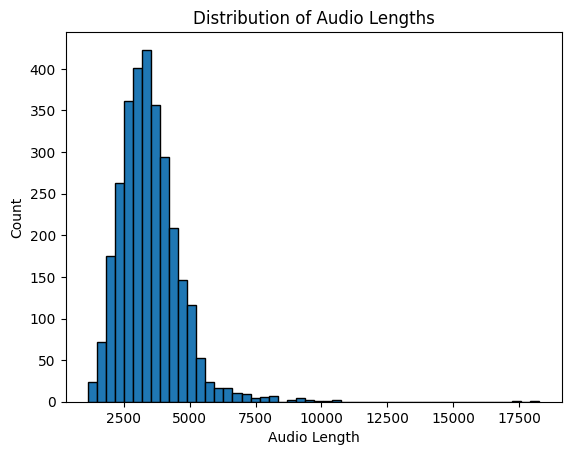

In [15]:
# one-hot encode
# label = 9 -> [0,0,0,0,0,0,0,0,0,1]
# 1 -> [0,1,0,0,0,0,0,0,0,0]

import matplotlib.pyplot as plt
%matplotlib inline

max_len = 0
lengths = []

for i in range(len(AudioData)):
    audio, _ = AudioData[i]
    length = audio.shape[1]
    max_len = max(max_len, length)
    lengths.append(length)

print("Max audio length:", max_len)

plt.hist(lengths, bins=50, edgecolor='black')
plt.xlabel("Audio Length")
plt.ylabel("Count")
plt.title("Distribution of Audio Lengths")
plt.show()

In [16]:
max_length = 8000

In [17]:
# redefine AudioDataSet
class AudioDataSet(Dataset) :
  def __init__(self, train=True):
    # get list of all wav files
    self.filelist = list(Path("./free-spoken-digit-dataset/recordings/").glob("*.wav"))

    # split test, train dataset
    self.train_list, self.test_list = self._split_data()
    if train :
      self.audio_list = self.train_list
    else:
      self.audio_list = self.test_list

  def _split_data(self):
    # 1: 9 = test: train
    # 6speaker * 0~9 * 50개  5개 -> test 45개 -> train
    test_postfix = [0,1,2,3,4]
    train_list = []
    test_list = []

    for path in self.filelist:
      # 9_nicolas_38.wav -> 38
      post_fix = int(path.stem.split("_")[-1])
      if post_fix in test_postfix:
        test_list.append(path)
      else:
        train_list.append(path)

    return train_list, test_list

  def __len__(self):
    # return length of dataset
    return len(self.audio_list)

  def __getitem__(self,idx):
    # return sample path
    audio_path =  self.audio_list[idx]
    y, sr = torchaudio.load(audio_path)

    # audio padding
    # wav file max_length = 18000
    padded = torch.zeros(20000)
    padded[:len(y[0])]= y[0]


    # one-hot encoding
    idx = int(audio_path.stem.split("_")[0])
    label = torch.zeros(10) # [0 ... 0] len = 10
    label[idx] = 1

    return padded[:8000], label

AudioData = AudioDataSet()


In [18]:
# define train and test dataset
train = AudioDataSet(train=True)
test = AudioDataSet(train=False)


In [19]:
# getitem
test[0]

(tensor([-0.0078,  0.0000, -0.0078,  ...,  0.0000,  0.0000,  0.0000]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [20]:
len(train), len(test)

(2700, 300)

## Model
- feature extraction
    - Mel-Spectrogram
    - Amplitude to DB
- model 정의

In [21]:
import torch.nn as nn

In [22]:
# define MyModel

from math import ceil

class MyModel(nn.Module):
  def __init__(self , hidden_dim = 1024):
    super().__init__()

    # define parameter
    self.n_mels = 64
    self.n_fft = 256
    self.hop_length=self.n_fft//2
    self.sr = 8000
    self.n_frames = ceil(8000/self.hop_length)

    self.n_classes = 10   # digit 0-9
    self.hidden_dim = hidden_dim


    # define mel_converter
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=self.sr,
                                                              n_fft=self.n_fft,
                                                              hop_length=self.hop_length,
                                                              n_mels=self.n_mels)
    # define db_converter
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

    # define layer sequence
    self.nn_layer = nn.Sequential(
                          nn.Linear(self.n_mels*self.n_frames,self.hidden_dim),
                          nn.ReLU(),
                          nn.Linear(self.hidden_dim,self.hidden_dim),
                          nn.ReLU(),
                          nn.Linear(self.hidden_dim,self.hidden_dim),
                          nn.ReLU(),
                          nn.Linear(self.hidden_dim,self.hidden_dim),
                          nn.ReLU(),
                          nn.Linear(self.hidden_dim,self.n_classes))

  def forward(self, x):
    # feature extraction
    # TODO
    # print(x.shape)
    spec = self.mel_converter(x) #mel-spectrogram

    # print(spec.shape)

    # [1, n_mels, n_frames]
    if spec.dim() > 2:
      spec = spec.reshape(spec.shape[0], -1)
    else: # [n_mels, n_frames]
      spec = spec.flatten()

    # print(spec.shape)
    spec = self.db_converter(spec)

    # print(spec.shape)
    # model
    # TODO
    x = self.nn_layer(spec)

    return x


model = MyModel()

In [23]:
# check train sample
sample, label = train[0]
print(sample)
print(label)


tensor([-0.0078, -0.0078, -0.0078,  ...,  0.0000,  0.0000,  0.0000])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [24]:
# check shape
out = model(sample)
out

tensor([ 0.3726, -0.8505, -1.6140, -0.4023, -0.2085,  1.2210, -0.1482, -1.4663,
         0.6541,  0.4109], grad_fn=<AddBackward0>)

In [25]:
# model output softmax
# torch.softmax(out, dim =-1).sum()
torch.softmax(out,dim=-1)

tensor([0.1265, 0.0372, 0.0174, 0.0583, 0.0708, 0.2955, 0.0752, 0.0201, 0.1676,
        0.1315], grad_fn=<SoftmaxBackward0>)

# Train

In [26]:
from tqdm.auto import tqdm

In [27]:
# device check
print(torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device,type(device))

True
cuda <class 'torch.device'>


In [28]:
# Train loop


# define epoch
n_epoch = 50

# define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)

# define batch size and train_loader, test_loader
bs = 64
train_loader = DataLoader(train,shuffle=True,batch_size=bs)
test_loader = DataLoader(test,shuffle=False,batch_size=bs)

# loss tracking
losses =[]

# model to device
model.to(device)

# train loop
for epoch in tqdm(range(n_epoch)):
  for batch in train_loader:
    # gradient init
    optim.zero_grad()

    # batch -> sample label
    samples, labels = batch

    # sample label -> upload to device
    samples = samples.to(device)
    labels = labels.to(device)

    # prediction
    pred = model(samples)

    # caculate loss
    loss = loss_fn(pred, labels)

    # gradient backpropagte
    loss.backward()

    # loss tracking
    losses.append(loss.item())

    # update model parameter
    optim.step()



  0%|          | 0/50 [00:00<?, ?it/s]

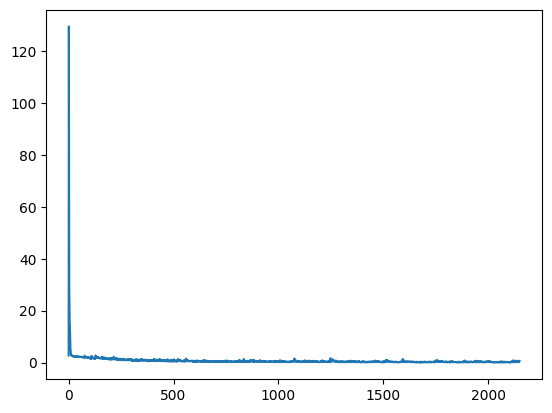

0.6370424032211304


In [29]:
# check loss

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)
plt.show()

print(losses[-1])

## Inference

accuracy

In [30]:
pred = model(samples.to('cuda')).argmax(dim=-1).cpu()
pred

tensor([5, 7, 9, 8, 8, 6, 2, 3, 3, 8, 9, 1])

In [31]:
labels.argmax(dim=-1)

tensor([5, 7, 9, 8, 8, 6, 2, 6, 3, 8, 9, 1], device='cuda:0')

In [32]:
(pred == labels.argmax(dim=-1).cpu()).sum() / len(pred)

tensor(0.9167)

In [33]:
# define validation function
def validation(model, val_loader, loss_fn):
  # 모델의 첫번째 파라미터의 디바이스를 호출
  device = next(model.parameters()).device

  val_loss = 0
  val_acc = 0
  cnt = 0

  with torch.no_grad(): #gradient calc X
    model.eval()
    for batch in tqdm(val_loader, leave= False, desc="valid"):
      x, y = batch

      x = x.to(device)
      y = y.to(device)

      pred = model(x)

      loss = loss_fn(pred, y)

      val_loss += loss

      cnt += (pred.argmax(dim=-1) == y.argmax(dim=-1)).sum()

    val_acc = cnt / len(val_loader.dataset)
    val_loss = val_loss / len(val_loader)

    model.train()

  return val_loss.item(), val_acc.item()





In [34]:
# check length of test dataset
len(test_loader.dataset)

300

In [35]:
len(test_loader)

5

In [36]:
# test set에 대해서 loss 및 accuracy 확인

validation(model, test_loader, loss_fn)

valid:   0%|          | 0/5 [00:00<?, ?it/s]

(0.47795841097831726, 0.8533333539962769)

In [37]:
model = MyModel()

n_epoch = 50

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)

bs = 64
train_loader = DataLoader(train,shuffle=True,batch_size=64)
test_loader = DataLoader(test,shuffle=False,batch_size=64)

losses =[]

val_losses =[]
val_accs = []

model.to('cuda')

with tqdm(range(n_epoch), desc="epoch") as pbar:
  for epoch in pbar:
    for batch in tqdm(train_loader, leave=False, desc="train"):
      # gradient init
      optim.zero_grad()

      # batch -> sample label
      samples, labels = batch

      # sample label -> upload to device
      samples = samples.to(device)
      labels = labels.to(device)

      # prediction
      pred = model(samples)

      # caculate loss
      loss = loss_fn(pred, labels)

      # gradient backpropagte
      loss.backward()

      # loss tracking
      losses.append(loss.item())

      # update model parameter
      optim.step()

    # test inference
    val_loss, val_acc = validation(model, test_loader, loss_fn)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    pbar.set_postfix(loss = loss.item(), val_loss=val_loss, val_acc=val_acc)


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]

valid:   0%|          | 0/5 [00:00<?, ?it/s]

## plotting loss, val_loss, val_acc

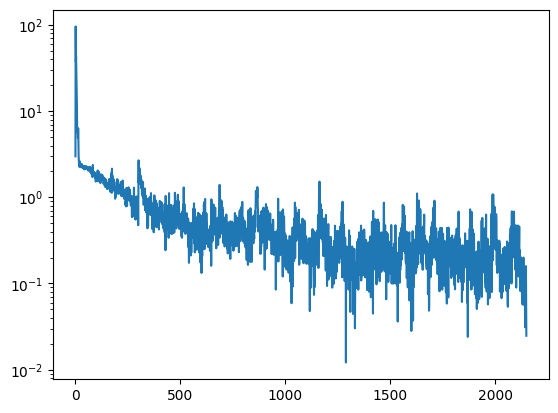

In [38]:
plt.plot(losses)
plt.yscale('log')

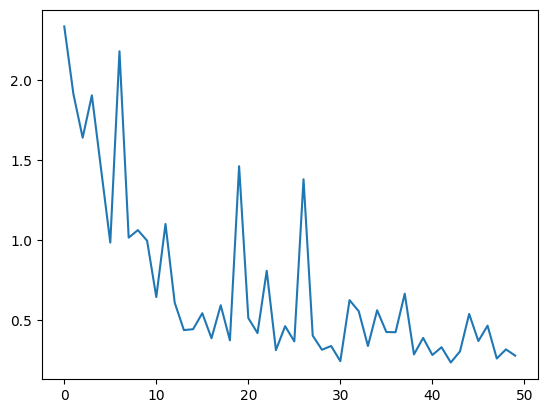

In [39]:
plt.plot(val_losses)

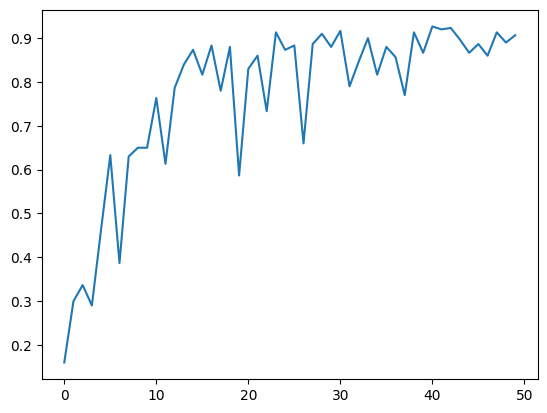

In [40]:
plt.plot(val_accs)